In [1]:
#pip install spopt

In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import numpy as np
import pulp
import shapely
import spopt
from spopt.locate import MCLP, simulated_geo_points
from pulp import GLPK
from pulp import PULP_CBC_CMD

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

In [3]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
import utm
import hdbscan
import os
import contextily as ctx
import folium
import webbrowser

In [5]:
def perform_hdbscan(data, min_cluster_size, min_samples, output_file_name=None):
    """
    Perform HDBSCAN clustering on provided geographic data and optionally save the results.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the longitude and latitude columns.
    - min_cluster_size (int): The minimum size of clusters; not less than this number of points will form a cluster.
    - min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point. This helps control the degree of noise.
    - output_file_name (str): Optional; The name of the file to save the clusters, saved to 'data/foot-traffic/output' if specified.
    
    Returns:
    - gpd.GeoDataFrame: GeoDataFrame with cluster labels.
    """
    # Clean dataset
    data = data.dropna(subset=['longitude', 'latitude'])

    # Convert DataFrame to GeoDataFrame with longitude and latitude
    gdf = gpd.GeoDataFrame(
        data,
        geometry=gpd.points_from_xy(data.longitude, data.latitude),
        crs='EPSG:4326'
    )

    # Convert to UTM coordinates for accurate distance measurement
    median_zone_number = int(gdf['geometry'].apply(lambda x: utm.latlon_to_zone_number(x.y, x.x)).median())
    utm_crs = f'+proj=utm +zone={median_zone_number} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
    gdf = gdf.to_crs(utm_crs)

    # Perform HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = clusterer.fit_predict(pd.DataFrame({'x': gdf.geometry.x, 'y': gdf.geometry.y}))
    gdf['cluster'] = labels

    # Save output if a file name is specified
    if output_file_name:
        # Define the directory for saving the file
        save_directory = "data/foot-traffic/output"
        os.makedirs(save_directory, exist_ok=True)

        # Full path for saving the file
        save_path = os.path.join(save_directory, output_file_name)

        # Save to GeoJSON
        gdf.to_file(save_path, driver='GeoJSON')
        print(f"Clusters saved to {save_path}")

    return gdf, utm_crs

In [6]:
def summarize_clusters(gdf):
    """
    Summarizes the clusters in a GeoDataFrame that includes a 'cluster' label column.

    Parameters:
    - gdf (gpd.GeoDataFrame): GeoDataFrame with a 'cluster' column where -1 indicates noise.
    
    Returns:
    - pd.DataFrame: DataFrame where each row represents a cluster with columns for the
                    number of points in the cluster, the cluster label, and the centroid geometry.
    """
    # Filter out the noise points
    clusters = gdf[gdf['cluster'] != -1]

    if clusters.empty:
        return pd.DataFrame(columns=['cluster_label', 'num_points', 'geometry'])

    # Group by cluster label
    grouped = clusters.groupby('cluster')

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'num_points': grouped.size(),  # Count points per cluster
        'centroid': grouped['geometry'].apply(lambda x: x.unary_union.centroid)  # Calculate centroid
    }).reset_index()

    # Rename columns appropriately
    summary_df.columns = ['cluster_label', 'num_points', 'geometry']

    return summary_df

In [4]:
data = pd.read_csv("output_month_01.csv")

In [7]:
# Read in foot traffic data to analyze cluster centroids

# Perform clustering
clustered_gdf, utm_crs = perform_hdbscan(data, min_cluster_size=50, min_samples=20)

# Restructure dataset and get centroids
cluster_summary = summarize_clusters(clustered_gdf)
cluster_summary

,cluster_label,num_points,geometry
0,0,1126,POINT (289326.361 2174797.911)
1,1,267,POINT (278239.702 2175444.336)
2,2,548,POINT (278042.607 2175546.334)
3,3,817,POINT (275887.335 2181282.256)
4,4,56,POINT (258695.667 2163512.322)
...,...,...,...
722,722,275,POINT (281329.319 2182447.529)
723,723,304,POINT (281337.743 2182433.363)
724,724,161,POINT (281343.242 2182428.645)
725,725,51,POINT (281402.008 2182295.932)


In [8]:
# pulp.COIN_CMD SOLVER is an interface to optimization solver developed by COIN-OR

# quantity demand point
CLIENT_COUNT = 727 # Nmber of foot traffic cluster centroids

# quantity supply points
FACILITY_COUNT = 200 # Max number of outdoor bins available

# maximum service radius (in distance units)
SERVICE_RADIUS = 400 # Max distance within which a bin is considered accessible to a demand point

# number of candidate facilities in optimal solution 
P_FACILITIES = 125 # The subset of facilities to activate within the network to meet the demand

# random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

# set the solver
solver = GLPK(msg=True)

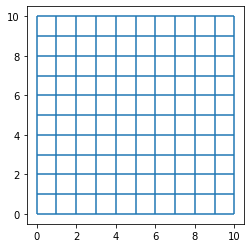

In [9]:
# Lattice 10x10
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

#Transform the spaghetti instance into a geodataframe
streets = spaghetti.element_as_gdf(ntw, arcs=True)
streets_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(streets["geometry"].buffer(0.5).unary_union),
    crs=streets.crs,
    columns=["geometry"],
)
streets.plot();

In [10]:
# Simulate points in a network
client_points = simulated_geo_points(
    streets_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED
)
facility_points = simulated_geo_points(
    streets_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

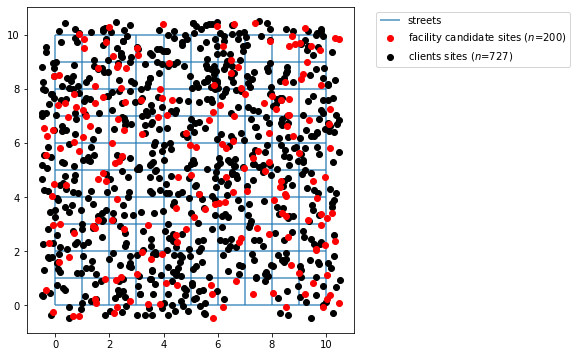

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facility_points.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
client_points.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [15]:
# For each client point the model supposes that there is a weight, this simulates it
np.random.seed(0)
ai = np.random.randint(1, 12, CLIENT_COUNT)
#ai

In [16]:
client_points["weights"] = ai
client_points["weights"].sum() # total value of the weighted clients

4325

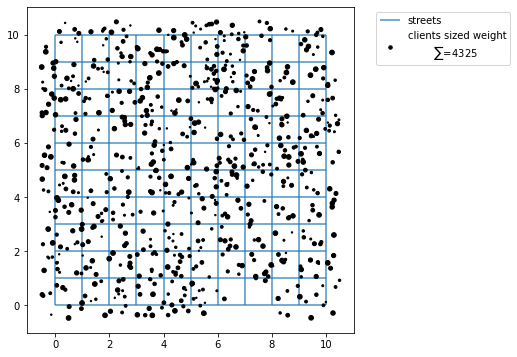

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
client_points.plot(
    ax=ax,
    color="black",
    label=f"clients sized weight\n\t$\\sum$={client_points['weights'].sum()}",
    markersize=ai*2
)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

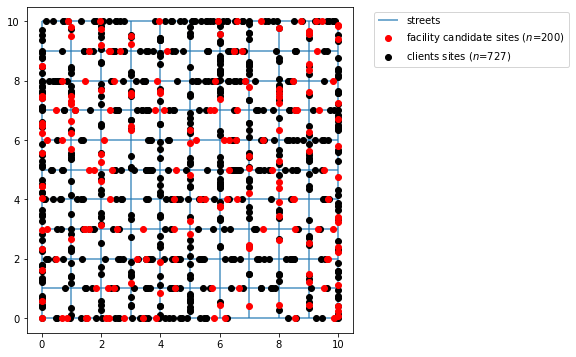

In [18]:
# Assign simulated points network locations
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(ntw, pp_name="clients", snapped=True)
clients_snapped.drop(columns=["id", "comp_label"], inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/libpysal#468
    ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(ntw, pp_name="facilities", snapped=True)
facilities_snapped.drop(columns=["id", "comp_label"], inplace=True)

fig, ax = plt.subplots(figsize=(6, 6))
streets.plot(ax=ax, alpha=0.8, zorder=1, label="streets")
facilities_snapped.plot(
    ax=ax, color="red", zorder=2, label=f"facility candidate sites ($n$={FACILITY_COUNT})"
)
clients_snapped.plot(ax=ax, color="black", label=f"clients sites ($n$={CLIENT_COUNT})")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1));

In [19]:
# Calculating the (network distance) cost matrix (between clients and facilities)
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix.shape

(727, 200)

In [21]:
# cost_matrix[:5,:]
# cost_matrix[-5:,:]

In [60]:
#pip install glpk 

In [22]:
# Solve the MCLP problem
mclp_from_cm = MCLP.from_cost_matrix(
    cost_matrix,
    ai,
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    name="mclp-network-distance"
)

In [23]:
solver = PULP_CBC_CMD()
mclp_from_cm.solve(solver)
print(mclp_from_cm)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydialo/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ml/xdk6f_rx15lgwxcw96g3t96c0000gn/T/989c04d76cad4c2c97a479533ced5657-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/ml/xdk6f_rx15lgwxcw96g3t96c0000gn/T/989c04d76cad4c2c97a479533ced5657-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 733 COLUMNS
At line 149642 RHS
At line 150371 BOUNDS
At line 151299 ENDATA
Problem MODEL has 728 rows, 927 columns and 146327 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4325 - 0.02 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -4325 to -1.79769e+308
Probing was tried 0 times and cre

In [24]:
print(f"{mclp_from_cm.perc_cov}% coverage is observed")

100.0% coverage is observed


In [25]:
# Define the decision variable names used for mapping later
# Lists the coordinates of each potential facility location in a point format
facility_points["dv"] = mclp_from_cm.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facilities_snapped["dv"] = facility_points["dv"]
facility_points

,geometry,dv
0,POINT (9.32146 3.15178),y0
1,POINT (8.53352 -0.04134),y1
2,POINT (0.68422 6.04557),y2
3,POINT (5.32799 4.10688),y3
4,POINT (3.18949 6.34771),y4
...,...,...
195,POINT (8.33743 4.59657),y195
196,POINT (7.99590 7.73701),y196
197,POINT (4.45761 2.61709),y197
198,POINT (1.06738 9.51092),y198


In [26]:
# Calculating Euclidean Distance from a GeoDataFrame
distance_metric = "euclidean"
clients_snapped["weights"] = client_points["weights"]
mclp_from_gdf = MCLP.from_geodataframe(
    clients_snapped,
    facilities_snapped,
    "geometry",
    "geometry",
    "weights",
    SERVICE_RADIUS,
    p_facilities=P_FACILITIES,
    distance_metric=distance_metric,
    name=f"mclp-{distance_metric}-distance"
)

In [27]:
mclp_from_gdf = mclp_from_gdf.solve(solver)
print(f"{mclp_from_gdf.perc_cov}% coverage is observed")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/lydialo/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ml/xdk6f_rx15lgwxcw96g3t96c0000gn/T/5a057ee9f2fc43ccb8363cfc33bd6dd4-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/ml/xdk6f_rx15lgwxcw96g3t96c0000gn/T/5a057ee9f2fc43ccb8363cfc33bd6dd4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 733 COLUMNS
At line 149642 RHS
At line 150371 BOUNDS
At line 151299 ENDATA
Problem MODEL has 728 rows, 927 columns and 146327 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4325 - 0.02 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -4325 to -1.79769e+308
Probing was tried 0 times and cre

In [29]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [34]:
def plot_results(model, p, facs, clis=None, ax=None):

    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 6))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis and i in model.fac2cli:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    streets.plot(ax=ax, alpha=1, color="black", zorder=1)
    legend_elements = [mlines.Line2D([], [], color="black", label="streets")]

    if plot_clis:
        if model.name.startswith("mclp") and model.n_cli_uncov:
            idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
            clis.iloc[idx].plot(ax=ax, fc='k', ec='k', marker='s', markersize=7, zorder=2)
            legend_elements.append(mlines.Line2D([], [], ms=3, label="Demand sites not covered", marker='s', markerfacecolor='k', markeredgecolor='k'))

    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, marker='*', markerfacecolor='brown', markeredgecolor='brown', label="Facility sites"))

    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors.get(fname, 'grey')  # Default color if not found
        if plot_clis and fname in cli_points:
            gdf = geopandas.GeoDataFrame(geometry=cli_points[fname])
            gdf.plot(ax=ax, zorder=zorder, ec='k', fc=cset, markersize=100 * markersize)
            legend_elements.append(mlines.Line2D([], [], marker='o', markerfacecolor=cset, markeredgecolor='k', ms=markersize + 7, label=f"Demand sites covered by {fname}"))

        ec, lw = ('r', 3) if predef else ('k', 2)
        facs.iloc[[fac]].plot(ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw)
        legend_elements.append(mlines.Line2D([], [], marker="*", ms=20, markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw, label=fname))

        zorder += 1
        markersize -= markersize_factor / p

    if not multi_plot:
        plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 0.7))

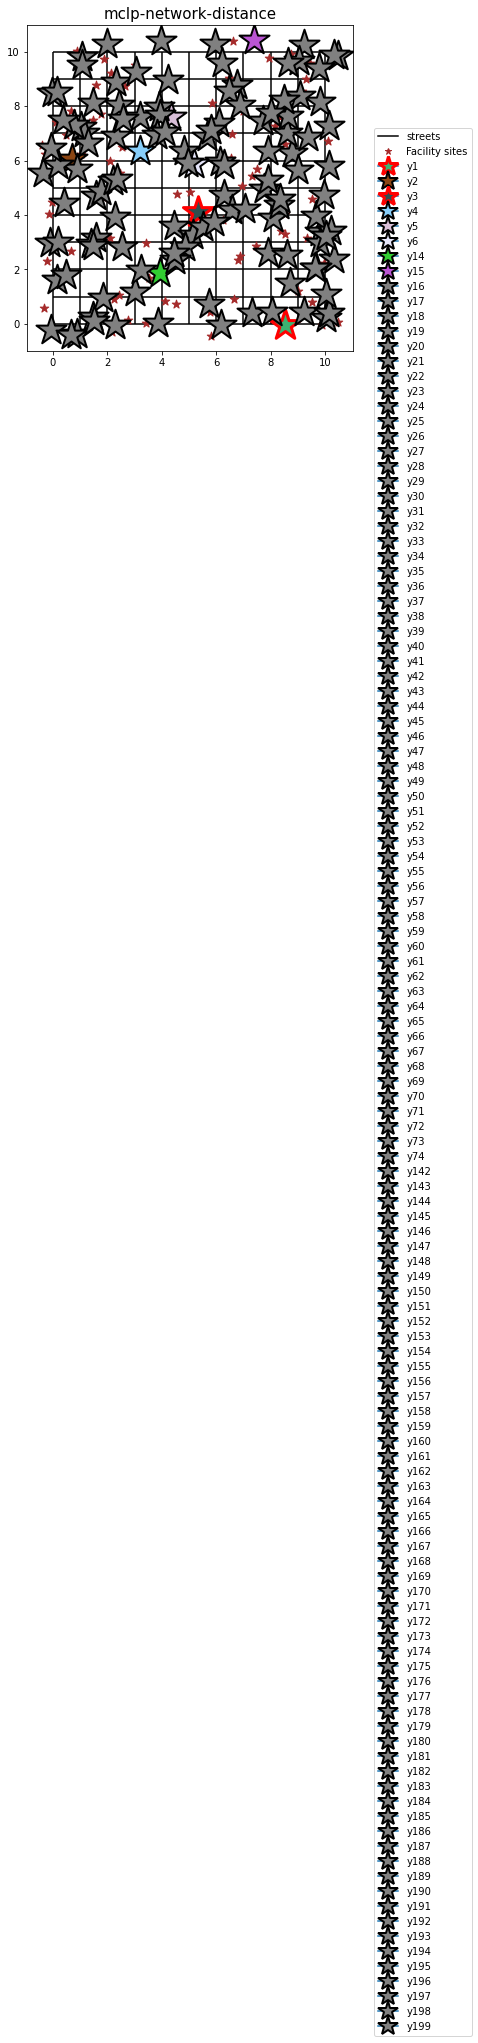

In [35]:
plot_results(mclp_from_cm, P_FACILITIES, facility_points, clis=client_points)

KeyError: 'y16'

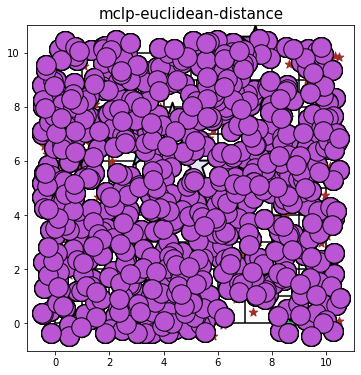

In [33]:
plot_results(mclp_from_gdf, P_FACILITIES, facility_points, clis=client_points)